# 1. Dependency libraries

In [1]:
from model.danet import danet_resnet101
from utils.loss import *
from utils.metrics import *
from dataloaders.generater import *
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from keras.utils.training_utils import multi_gpu_model

Using TensorFlow backend.


# 2. Params

In [2]:
# network params
BatchSize = 5
NumChannels = 3
ImgHeight = 512
ImgWidth = 512
NumClass = 1

# training params
GPUs = '0, 1, 2, 3'
os.environ["CUDA_VISIBLE_DEVICES"] = GPUs
Optimizer = 'Adam'  # SGD(lr=0.01, momentum=0.9, nesterov=True)
Loss = ce_jaccard_loss
Metrics = ['accuracy', iou]
NumEpochs = 100
Patience = 10

# data params
TrainImageDir = '/data/dh_zhu/cong/AerialImageDataset/train/images/'
ValImageDir = '/data/dh_zhu/cong/AerialImageDataset/val/images/'

# visualization params
metric_list = ['acc', 'iou']

In [3]:
model = danet_resnet101(ImgHeight, ImgWidth, NumChannels, NumClass)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [4]:
class ParallelModelCheckpoint(ModelCheckpoint):
    def __init__(self,model,filepath, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1):
        self.single_model = model
        super(ParallelModelCheckpoint,self).__init__(filepath, monitor, verbose,save_best_only, save_weights_only,mode, period)

    def set_model(self, model):
        super(ParallelModelCheckpoint,self).set_model(self.single_model)

In [5]:
paralle_model = multi_gpu_model(model, gpus=4)
paralle_model.compile(optimizer=Optimizer, loss=Loss, metrics=Metrics)
model_path = "danet_resnet101-{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}-{val_iou:.4f}.hdf5"
model_checkpoint = ParallelModelCheckpoint(model, model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=False)
# model_checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=False)

In [6]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=Patience)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=2)
check_point_list = [model_checkpoint, early_stop, reduce_lr]

In [7]:
train_paths, val_paths = get_data_paths(TrainImageDir, ValImageDir)
train_steps = len(train_paths) // BatchSize
val_steps = len(val_paths) // BatchSize

In [8]:
result = paralle_model.fit_generator(
    generator=batch_generator(train_paths, BatchSize, flag='train'),
    steps_per_epoch=train_steps,
    epochs=NumEpochs,
    verbose=1,
    validation_data=batch_generator(val_paths, BatchSize, flag='test'),
    validation_steps=val_steps,
    callbacks=check_point_list)

Epoch 1/100
5239/5239 [==============================] - 5406s 1s/step - loss: 1.5943 - acc: 0.8639 - iou: 0.3677 - val_loss: 2.4829 - val_acc: 0.7773 - val_iou: 0.3115

Epoch 00001: saving model to danet_resnet101-01-2.4829-0.7773-0.3115.hdf5
Epoch 2/100
5239/5239 [==============================] - 5308s 1s/step - loss: 1.1217 - acc: 0.9113 - iou: 0.5112 - val_loss: 1.7003 - val_acc: 0.8952 - val_iou: 0.2874

Epoch 00002: saving model to danet_resnet101-02-1.7003-0.8952-0.2874.hdf5
Epoch 3/100
5239/5239 [==============================] - 5323s 1s/step - loss: 0.9739 - acc: 0.9204 - iou: 0.5561 - val_loss: 1.7768 - val_acc: 0.8895 - val_iou: 0.2506

Epoch 00003: saving model to danet_resnet101-03-1.7768-0.8895-0.2506.hdf5
Epoch 4/100
5239/5239 [==============================] - 5319s 1s/step - loss: 0.8804 - acc: 0.9260 - iou: 0.5868 - val_loss: 1.8088 - val_acc: 0.8922 - val_iou: 0.1859

Epoch 00004: saving model to danet_resnet101-04-1.8088-0.8922-0.1859.hdf5
Epoch 5/100
5239/5239 [=

/data/dh_zhu/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "under right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


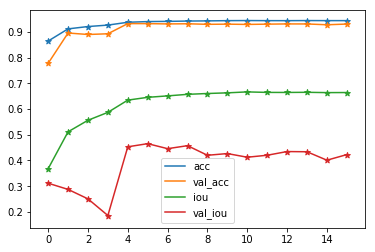

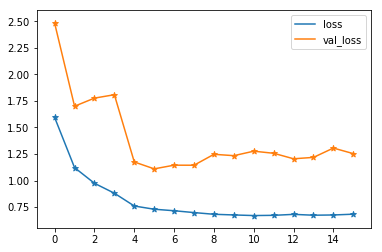

In [9]:
import matplotlib.pyplot as plt
plt.figure()
for metric in metric_list:
    plt.plot(result.epoch, result.history[metric], label=metric)
    plt.scatter(result.epoch, result.history[metric], marker='*')
    val_metric = 'val_' + metric
    plt.plot(result.epoch, result.history[val_metric], label=val_metric)
    plt.scatter(result.epoch, result.history[val_metric], marker='*')
plt.legend(loc='under right')
plt.show()

plt.figure()
plt.plot(result.epoch, result.history['loss'], label="loss")
plt.plot(result.epoch, result.history['val_loss'], label="val_loss")
plt.scatter(result.epoch, result.history['loss'], marker='*')
plt.scatter(result.epoch, result.history['val_loss'], marker='*')
plt.legend(loc='upper right')
plt.show()